In [207]:
import pandas as pd
import numpy as np

import seaborn as sns
import warnings
warnings.simplefilter("ignore")

import nltk
import pymorphy2
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVC

import pickle

%matplotlib inline

In [208]:
# uncomment if nltk not run
# nltk.download('punkt')
# nltk.download('stopwords')

In [209]:
data = pd.read_csv("./data/df.csv", index_col=0)
data[:3]

,text,score
0,Кредит оформлял в офисе банка: «Дополнительный...,3
1,По своему бизнесу общаюсь с большим количество...,5
2,"Уважаемый банк! Объясните мне, как давнему ваш...",2


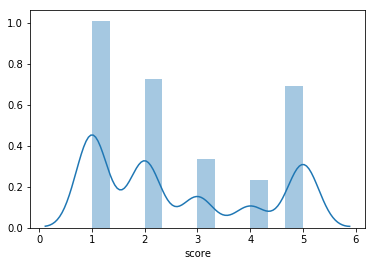

In [210]:
sns.distplot(data.score);

In [211]:
X = data.text
y = data.score
# y = list(map(lambda x: 1 if x >= 3 else 0, data.score))

In [212]:
y = np.array(y)

In [213]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 5]), array([1899, 1365,  635,  441, 1296]))

Видим, что классы немного не сбалансирвоанные, поэтому для нормального обучения будем использовать stratified - методы кросс-валидации. Это будет хорошо по точности и достаточно просто в реализации

## 1. Подготовка текстовых данных

In [214]:
class Vectorizer:
    def __init__(self, lang="russian"):
        self.stemmer = pymorphy2.MorphAnalyzer()
        self.tokenizer = nltk.tokenize.word_tokenize
        self.stopwords = nltk.corpus.stopwords.words(lang)
        
    def is_word(self, string):
        return string.isalpha()

    def text_preprocessing(self, text):
        tokenized_text = self.tokenizer(text.lower())
        filtered_text = list(
            filter(lambda word: self.is_word(word) and word not in self.stopwords, tokenized_text)
        )
        return " ".join(list(map(lambda word: self.stemmer.parse(word)[0].normal_form, filtered_text)))
    
    def set_tf_idf_vectorizer(self, tf_idf_vectorizer):
        self.tf_idf_vectorizer = tf_idf_vectorizer
    
    def vectorize(self, text):
        text_for_vectorize = self.text_preprocessing(text)
        return self.tf_idf_vectorizer.transform([text_for_vectorize])

In [215]:
vectorizer = Vectorizer()

In [216]:
X = X.apply(lambda x: vectorizer.text_preprocessing(x))

Видим, что выборка несбалансированная. Первое, что пришло в голову -- это дополнить ее семплами из деффицитного класса

In [217]:
# non_one_X = X[np.where(y > 1)[0]]
# non_one_y = y[np.where(y > 1)[0]]

In [218]:
# print(non_one_X.shape, non_one_y.shape)

In [219]:
# X = list(X) + list(non_one_X)
# y = list(y) + list(non_one_y)
# X = np.array(X)
# y = np.array(y)

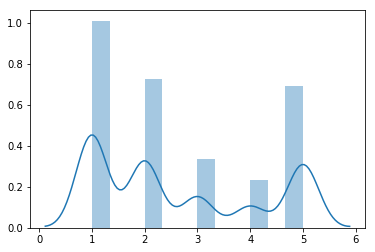

In [220]:
sns.distplot(y);

In [221]:
for tr, te in StratifiedKFold(y=y, n_folds=5, shuffle=True, random_state=42):
    tfidf = TfidfVectorizer(ngram_range=(1, 2))
    X_train_tf_idf = tfidf.fit_transform(X[tr])
    X_test_tf_idf = tfidf.transform(X[te])
    rf = RandomForestClassifier()
    rf.fit(X_train_tf_idf, y[tr])
    print(np.sum(rf.predict(X_test_tf_idf) == y[te]) / len(y[te]))
    print(mean_absolute_error(y[te], rf.predict(X_test_tf_idf)))
    print("=" * 50)

0.4402125775022144
1.0611160318866253
0.42857142857142855
1.087843833185448
0.44631765749778174
1.0390417036379769
0.4259094942324756
1.1348713398402839
0.458259325044405
1.0550621669626998


In [222]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_all_tfidf = tfidf.fit_transform(X)

In [223]:
rf = RandomForestClassifier()
rf.fit(X_all_tfidf, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [225]:
vectorizer.set_tf_idf_vectorizer(tfidf)
print(rf.predict(vectorizer.vectorize("Благодарность сотруднику банка: Хочу сказать спасибо! Вы мне сильно помогли")))

[5]


In [226]:
with open("./deploy_server/models/vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [227]:
with open("./deploy_server/models/classifier.pkl", "wb") as f:
    pickle.dump(rf, f)